# Alpaca/Not Alpaca classifier (Transfer Learning with MobileNetV2)

A pre-trained model is a network that's already been trained on a large dataset and saved, which allows us to use it to customize your own model cheaply and efficiently. We'll be using, MobileNetV2, was designed to provide fast and computationally efficient performance. It's been pre-trained on ImageNet, a dataset containing over 14 million images and 1000 classes.

## Table of Content

- [1 - Packages](#1)
    - [1.1 Create the Dataset and Split it into Training and Validation Sets](#1-1)
- [2 - Preprocess and Augment Training Data](#2)
    - [Data_augmenter](#1)
- [3 - Using MobileNetV2 for Transfer Learning](#3)
    - [3.1 - Inside a MobileNetV2 Convolutional Building Block](#3-1)
    - [3.2 - Layer Freezing with the Functional API](#3-2)
        - [Alpaca_model](#2)
    - [3.3 - Fine-tuning the Model](#3-3)
        - [3](#3)

<a name='1'></a>
## 1 - Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation

<a name='1-1'></a>
### 1.1 Creating the Dataset and Splitting it into Training and Validation Sets

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
directory = "dataset/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 327 files belonging to 2 classes.
Using 262 files for training.
Found 327 files belonging to 2 classes.
Using 65 files for validation.


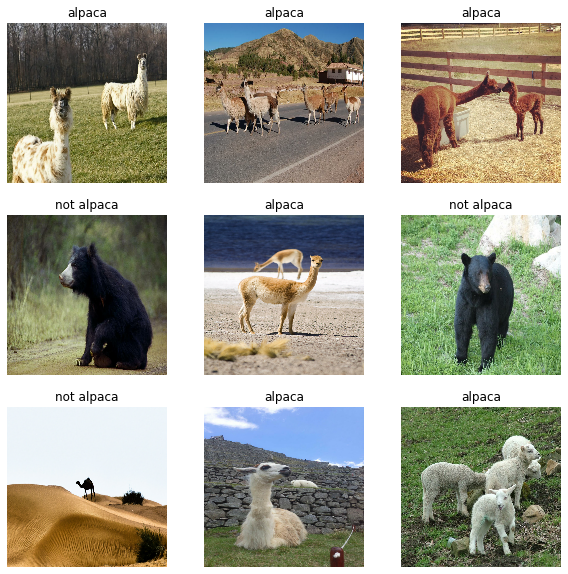

In [3]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

<a name='2'></a>
## 2 - Preprocess and Augment Training Data

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [7]:
def data_augmenter():
    '''
    Create a Sequential model composed of 2 layers
    Returns:
        tf.keras.Sequential
    '''
    data_augmentation = tf.keras.Sequential()
    data_augmentation.add(RandomFlip("horizontal"))
    data_augmentation.add(RandomRotation(0.2)) 
    return data_augmentation

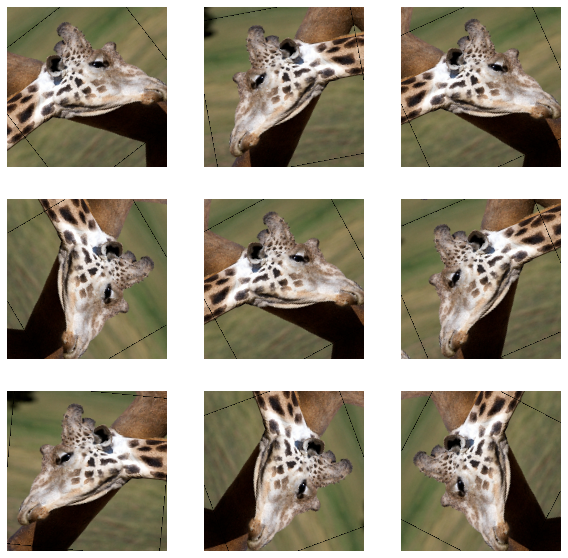

In [9]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

<a name='3'></a>
## 3 - Using MobileNetV2 for Transfer Learning

Let's try to train your base model using all the layers from the pretrained model.

In [11]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

14540800/14536120 [==============================] - 0s 0us/step


In [12]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [13]:
nb_layers = len(base_model.layers)
print(base_model.layers[nb_layers - 2].name)
print(base_model.layers[nb_layers - 1].name)

global_average_pooling2d
predictions


The first batch from the tensorflow dataset to use the images, and run it through the MobileNetV2 base model to test out the predictions on some of our images. 

In [14]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [15]:
#Shows the different label probabilities in one tensor 
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 0, 0], dtype=int32)>

The predictions returned by the base model below follow this format:

First the class number, then a human-readable label, and last the probability of the image belonging to that class. You'll notice that there are two of these returned for each image in the batch - these the top two probabilities returned for that image.

In [16]:
base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

40960/35363 [==================================] - 0s 0us/step


[[('n02489166', 'proboscis_monkey', 0.10329965),
  ('n02102177', 'Welsh_springer_spaniel', 0.07883611)],
 [('n02125311', 'cougar', 0.1654676), ('n02389026', 'sorrel', 0.10764261)],
 [('n02437312', 'Arabian_camel', 0.2923283),
  ('n02437616', 'llama', 0.27713484)],
 [('n03944341', 'pinwheel', 0.31154886), ('n03047690', 'clog', 0.052500293)],
 [('n02454379', 'armadillo', 0.73107153),
  ('n01990800', 'isopod', 0.038719974)],
 [('n02437312', 'Arabian_camel', 0.25663644),
  ('n02422106', 'hartebeest', 0.12122728)],
 [('n02437616', 'llama', 0.6612557),
  ('n02090721', 'Irish_wolfhound', 0.23782855)],
 [('n02133161', 'American_black_bear', 0.82735676),
  ('n02134418', 'sloth_bear', 0.02925945)],
 [('n01518878', 'ostrich', 0.9267562),
  ('n02002724', 'black_stork', 0.0017766367)],
 [('n01518878', 'ostrich', 0.94954586),
  ('n02018795', 'bustard', 0.0028661634)],
 [('n02437616', 'llama', 0.8699833), ('n02412080', 'ram', 0.076757126)],
 [('n02415577', 'bighorn', 0.2429446), ('n02412080', 'ram', 

There's a whole lot of labels here, some of them wrong, but none of them say "alpaca."

This is because MobileNet pretrained over ImageNet doesn't have the correct labels for alpacas, so when we use the full model, all we get is a bunch of incorrectly classified images.

Fortunately, we can delete the top layer, which contains all the classification labels, and create a new classification layer.

<a name='3-2'></a>
### 3.2 - Layer Freezing with the Functional API

<a name='2'></a>
### Alpaca_model

In [19]:
def alpaca_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet') # From imageNet
    
    # freeze the base model (non trainable)
    base_model.trainable = False 

    # The input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    #data augmentation to the inputs
    x =  data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(x) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    x = tfl.GlobalAveragePooling2D()(x)
    x = tfl.Dropout(0.2)(x)
        
    prediction_layer = tfl.Dense(1)
    outputs = prediction_layer(x) 
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [20]:
model2 = alpaca_model(IMG_SIZE, data_augmentation)

In [22]:
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [23]:
initial_epochs = 5
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/5
9/9 [==============================] - 9s 967ms/step - loss: 0.7449 - accuracy: 0.5687 - val_loss: 0.6636 - val_accuracy: 0.5538
Epoch 2/5
9/9 [==============================] - 7s 824ms/step - loss: 0.6637 - accuracy: 0.5954 - val_loss: 0.5363 - val_accuracy: 0.6308
Epoch 3/5
9/9 [==============================] - 7s 801ms/step - loss: 0.5697 - accuracy: 0.7595 - val_loss: 0.4488 - val_accuracy: 0.7077
Epoch 4/5
9/9 [==============================] - 7s 801ms/step - loss: 0.4646 - accuracy: 0.7099 - val_loss: 0.4080 - val_accuracy: 0.6769
Epoch 5/5
9/9 [==============================] - 7s 810ms/step - loss: 0.4159 - accuracy: 0.8092 - val_loss: 0.3501 - val_accuracy: 0.8000


The training and validation accuracy:

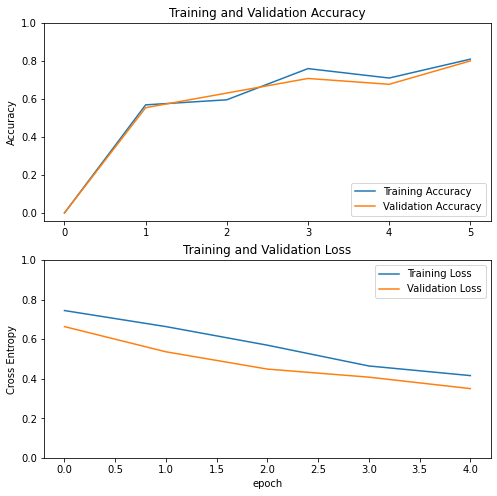

In [24]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [25]:
class_names

['alpaca', 'not alpaca']

The results are ok, but could be better. Next,let's try some fine-tuning.

<a name='3-3'></a>
### 3.3 - Fine-tuning the Model

In [26]:
base_model = model2.layers[4]
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tuning from this layer onwards
fine_tune_at = 120

# Freezing all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = True
    
#  BinaryCrossentropy loss function
loss_function= tf.keras.losses.BinaryCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam(lr=0.1 * base_learning_rate)
# Use accuracy as evaluation metric
metrics=['accuracy']

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  155


In [2]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

NameError: name 'initial_epochs' is not defined

In [1]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

NameError: name 'acc' is not defined

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()